In [ ]:
!apt-get update && apt-get install -y ffmpeg
!mkdir -p frames
# !ffmpeg -i kitti-sample.mp4 -vsync vfr -q:v 3 -vf "scale=640:-1" frames/frame_%03d.png
!ffmpeg -i kitti-sample.mp4 -q:v 1 frames/frame_%03d.png
!ls frames | wc -l
!zip -r extracted_frames.zip frames/
from google.colab import files
files.download("extracted_frames.zip")

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,788 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,243 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,82

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!unzip -q extracted_frames.zip -d frames

In [ ]:
import numpy as np
import cv2 as cv
import os
from tqdm import tqdm
import numpy.linalg as la
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Camera intrinsic matrix
K = np.array([
    [7.215377e+02, 0.000000e+00, 6.095593e+02],
    [0.000000e+00, 7.215377e+02, 1.728540e+02],
    [0.000000e+00, 0.000000e+00, 1.000000e+00]
])

def track_features(img1, img2):
    """
    Detect and match features between two images using SIFT and FLANN-based matcher.

    Parameters:
    img1 (numpy.ndarray): First input image.
    img2 (numpy.ndarray): Second input image.

    Returns:
    tuple: Matched feature points in both images as NumPy float32 arrays.
    """
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    des1 = np.float32(des1)
    des2 = np.float32(des2)
    # FLANN parameters
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    ptsA, ptsB = [], []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            ptsA.append(kp1[m.queryIdx].pt)
            ptsB.append(kp2[m.trainIdx].pt)

    return np.float32(ptsA), np.float32(ptsB)

def getTrajectory(images, K, ground_truth_translations):
    num_frames = len(images)
    trajectory = [np.eye(4)]
    for i in tqdm(range(num_frames - 1)):
        img1, img2 = images[i], images[i + 1]
        ptsA, ptsB = track_features(img1, img2)

        if len(ptsA) < 8:
            print(f"Frame {i}: Not enough feature matches!")
            continue

        # Compute Fundamental Matrix using 8-point algorithm with RANSAC
        F, _ = getFundamentalMatRANSAC(ptsA, ptsB, tol=1.0)
        E = K.T @ F @ K
        _, R, t, _ = cv.recoverPose(E, ptsA, ptsB, K)
        R_inv = R.T
        t_inv = -R.T @ t
        t_gt = ground_truth_translations[i]
        scale=1/1.5
        t_scaled = scale * t_inv

        T = np.eye(4)
        T[:3, :3] = R_inv
        T[:3, 3] = t_scaled.flatten()

        C_new = trajectory[-1] @ T
        trajectory.append(C_new)

    kitti_trajectory = [pose[:3].reshape(-1) for pose in trajectory]

    return kitti_trajectory

def randomSampleCorrPoint(ptsA, ptsB, num_point=8):
    if num_point >= len(ptsA):
        return ptsA, ptsB
    else:
        rng = np.random.default_rng()
        point_index = rng.choice(np.arange(len(ptsA)), size=num_point, replace=False)# Randomly selects 8 unique indices from the list of available correspondences.With no repetition
        sample_ptsA = ptsA[point_index, :]
        sample_ptsB = ptsB[point_index, :]
        return sample_ptsA, sample_ptsB

def conv2HomogeneousCor(ptsA, ptsB):
    if ptsA.ndim == 1:
        ptsA_homo = np.pad(ptsA, (0, 1), "constant", constant_values=1.0)
        ptsB_homo = np.pad(ptsB, (0, 1), "constant", constant_values=1.0)
    else:
        ptsA_homo = np.pad(ptsA, [(0, 0), (0, 1)], "constant", constant_values=1.0)# Add 1 column to the end ... appending 1.0 to each row.
        ptsB_homo = np.pad(ptsB, [(0, 0), (0, 1)], "constant", constant_values=1.0)
    return np.float64(ptsA_homo), np.float64(ptsB_homo)

def getNormalisationMat(pts):
    pts = np.float64(pts)
    mean = np.array(np.sum(pts, axis=0) / len(pts), dtype=np.float64)
    scale = np.sum(la.norm(pts - mean, axis=1), axis=0) / (len(pts) * np.sqrt(2.0))
    normalisationMat = np.array([
        [1.0 / scale, 0.0, -mean[0] / scale],
        [0.0, 1.0 / scale, -mean[1] / scale],
        [0.0, 0.0, 1.0],
    ], dtype=np.float64)# conditioning
    return normalisationMat

def getFundamentalMatrix(ptsA, ptsB, num_point=8):
    ptsA = np.float64(ptsA)
    ptsB = np.float64(ptsB)
    sample_ptsA, sample_ptsB = randomSampleCorrPoint(ptsA, ptsB, num_point)
    normalisationMat_A = getNormalisationMat(ptsA)
    normalisationMat_B = getNormalisationMat(ptsB)
    sample_ptsA, sample_ptsB = conv2HomogeneousCor(sample_ptsA, sample_ptsB)
    sample_ptsA_normal = np.float64([normalisationMat_A @ s_ptA for s_ptA in sample_ptsA])
    sample_ptsB_normal = np.float64([normalisationMat_B @ s_ptB for s_ptB in sample_ptsB])
    design_matrix = np.array([
        (np.expand_dims(b, axis=1) @ np.expand_dims(a, axis=0)).flatten()
        for a, b in zip(sample_ptsA_normal, sample_ptsB_normal)
    ])
    U_des, s_des, VT_des = la.svd(design_matrix)

    # Find the vector V_i with the least corresponding singular value
    f_vec = VT_des[-1, :]
    # Reform draft F from V_i
    f = np.float64(f_vec.reshape((3, 3)))
    # SVD draft F
    U_f, s_f, VT_f = la.svd(f)
    # Set the least singular value of draft F to 0
    s_f[-1] = 0
    s_f_new = np.diag(s_f)
    # Reconstruct F using the new S and draft U, draft V
    F_n = U_f @ s_f_new @ VT_f
    # De-normalise
    F = normalisationMat_B.T @ F_n @ normalisationMat_A
    F = F / F[-1, -1]

    return F

def getCorrespondencesEpilines(ptsA, ptsB, FundMat):
    ptsA = np.float64(ptsA)
    ptsB = np.float64(ptsB)
    if ptsA.ndim == 1:
        linesA = np.array(ptsB @ FundMat, dtype=np.float64)
        linesB = np.array(FundMat @ ptsA.T, dtype=np.float64)
        aA, bA, cA = linesA
        aB, bB, cB = linesB
        linesA = linesA / np.sqrt(aA * aA + bA * bA)
        linesB = linesB / np.sqrt(aB * aB + bB * bB)
    else:
        linesA = np.array([pB @ FundMat for pB in ptsB], dtype=np.float64)
        linesB = np.array([FundMat @ pA.T for pA in ptsA], dtype=np.float64)
        linesA = np.array([
            np.array([a / np.sqrt(a * a + b * b), b / np.sqrt(a * a + b * b), c / np.sqrt(a * a + b * b)], dtype=np.float64)
            for a, b, c in linesA
        ], dtype=np.float64)
        linesB = np.array([
            np.array([a / np.sqrt(a * a + b * b), b / np.sqrt(a * a + b * b), c / np.sqrt(a * a + b * b)], dtype=np.float64)
            for a, b, c in linesB
        ], dtype=np.float64)
    return linesA, linesB

def getFundamentalMatRANSAC(ptsA, ptsB, tol, num_sample=8, confidence=0.99):
    best_inlier_num = 0 # The number of inliers for the best fundamental matrix
    best_inlier = np.zeros(len(ptsA))
    best_F = None # The actual best fundamental matrix F found so far
    tol = np.float64(tol)
    iterations = int(np.ceil(np.log10(1 - confidence) / np.log10(1 - np.float_power(0.5, num_sample))))

    for _ in tqdm(range(iterations)):
        sample_ptsA, sample_ptsB = randomSampleCorrPoint(ptsA, ptsB, num_sample)
        F = getFundamentalMatrix(sample_ptsA, sample_ptsB)
        inlier = np.zeros(len(ptsA), dtype=np.float64)
        inlier_count = 0

        for i, (ptA, ptB) in enumerate(zip(ptsA, ptsB)):
            ptA_homo, ptB_homo = conv2HomogeneousCor(ptA, ptB)
            l_A, l_B = getCorrespondencesEpilines(ptA_homo, ptB_homo, F)
            l_A = np.float64(l_A)
            l_B = np.float64(l_B)
            err_A = np.float64(abs(l_A @ ptA_homo))
            err_B = np.float64(abs(l_B @ ptB_homo))
            if err_A <= tol and err_B <= tol:
                inlier[i] = 1

        if np.sum(inlier) > best_inlier_num:
            best_inlier = inlier
            best_inlier_num = np.sum(inlier)
            best_F = F

    return best_F, best_inlier

100%|██████████| 800/800 [03:02<00:00,  4.38it/s]


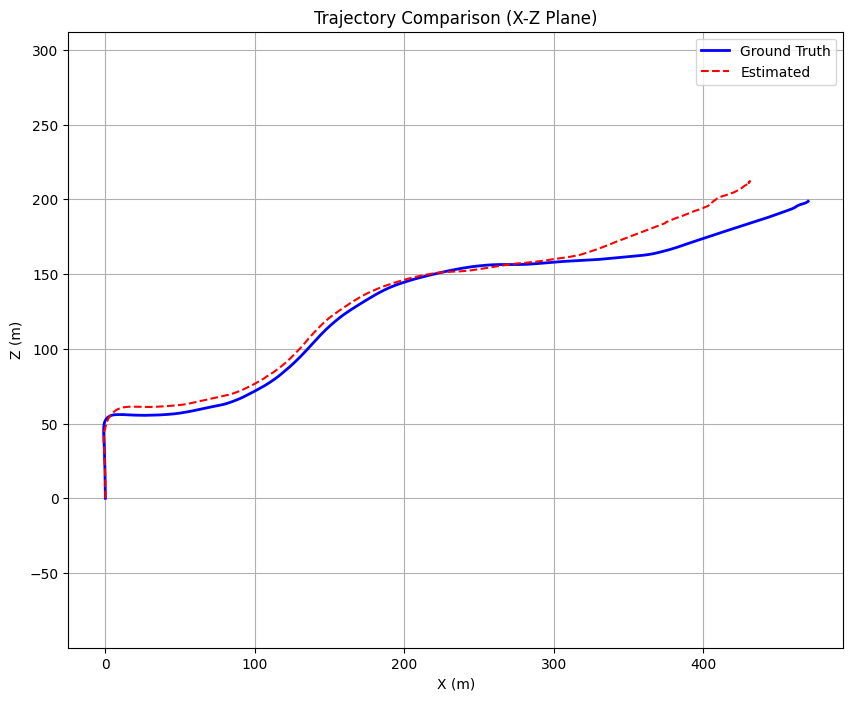

Run the following command to evaluate error:
evo_traj kitti ground-truth.txt my-result.txt -va --plot --plot_mode xz


In [ ]:
def save_trajectory(trajectory, filename="my-result.txt"):
    """
    Save trajectory in KITTI format: 3x4 matrix flattened row-wise (12 values per line)
    Each line: r11 r12 r13 tx r21 r22 r23 ty r31 r32 r33 tz
    """
    with open(filename, "w") as f:
        for pose in trajectory:
            line = " ".join(map(str, pose))  # pose is already flattened 3x4
            f.write(line + "\n")

def plot_trajectories(gt_traj, est_traj):
    gt_x = gt_traj[:, 3]   # tx
    gt_z = gt_traj[:, 11]  # tz

    est_x = est_traj[:, 3]
    est_z = est_traj[:, 11]

    plt.figure(figsize=(10, 8))
    plt.plot(gt_x, gt_z, label="Ground Truth", color="blue", linewidth=2)
    plt.plot(est_x, est_z, label="Estimated", color="red", linestyle='--')
    plt.xlabel("X (m)")
    plt.ylabel("Z (m)")
    plt.title("Trajectory Comparison (X-Z Plane)")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

frames_dir = "frames"
frame_files = sorted(os.listdir(frames_dir))
gray_images = [cv.imread(os.path.join(frames_dir, f), cv.IMREAD_GRAYSCALE) for f in frame_files if f.endswith('.png')]

# Load ground truth translations (only tx, ty, tz)
ground_truth_translations = np.loadtxt("ground-truth.txt")[:, [3, 7, 11]]

# Estimate trajectory in KITTI pose format
trajectory = getTrajectory(gray_images, K, ground_truth_translations)

ground_truth_points = np.loadtxt("ground-truth.txt")

estimated_trajectory = np.array(trajectory)

# Save estimated trajectory to file
save_trajectory(estimated_trajectory)

# Plot the trajectories (X-Z)
plot_trajectories(ground_truth_points, estimated_trajectory)

print("Run the following command to evaluate error:")
print("evo_traj kitti ground-truth.txt my-result.txt -va --plot --plot_mode xz")


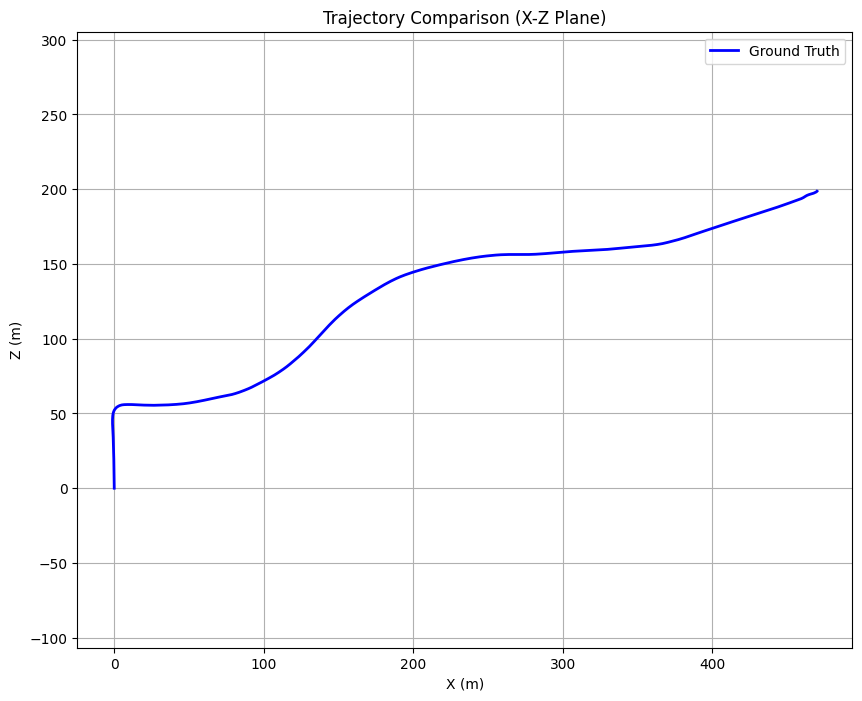

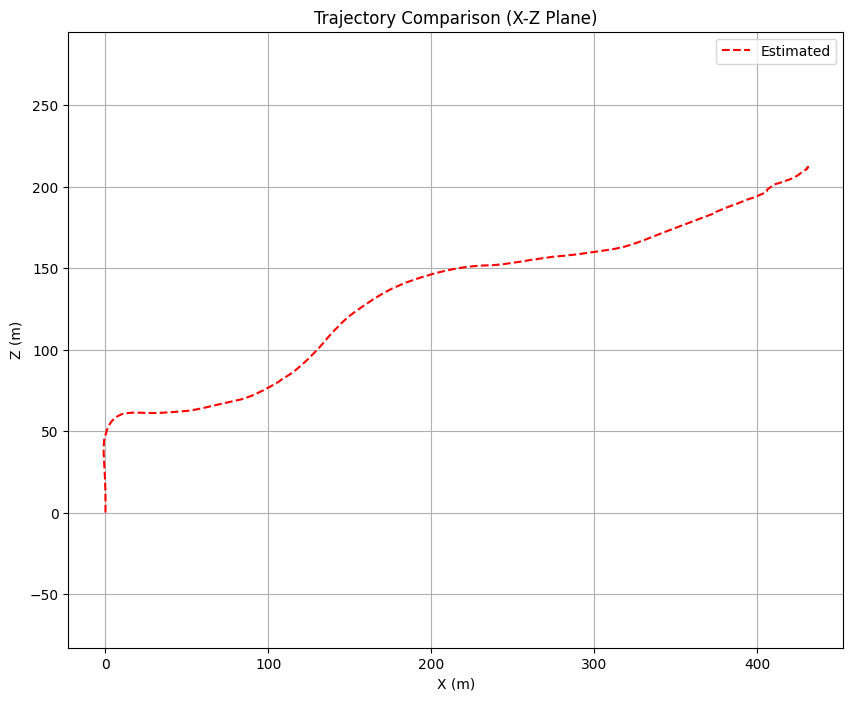

In [ ]:
def plot_trajectories1(gt_traj, est_traj):
    gt_x = gt_traj[:, 3]   # tx
    gt_z = gt_traj[:, 11]  # tz

    est_x = est_traj[:, 3]
    est_z = est_traj[:, 11]

    plt.figure(figsize=(10, 8))
    plt.plot(gt_x, gt_z, label="Ground Truth", color="blue", linewidth=2)
    # plt.plot(est_x, est_z, label="Estimated", color="red", linestyle='--')
    plt.xlabel("X (m)")
    plt.ylabel("Z (m)")
    plt.title("Trajectory Comparison (X-Z Plane)")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()
def plot_trajectories2(gt_traj, est_traj):
    gt_x = gt_traj[:, 3]   # tx
    gt_z = gt_traj[:, 11]  # tz

    est_x = est_traj[:, 3]
    est_z = est_traj[:, 11]

    plt.figure(figsize=(10, 8))
    # plt.plot(gt_x, gt_z, label="Ground Truth", color="blue", linewidth=2)
    plt.plot(est_x, est_z, label="Estimated", color="red", linestyle='--')
    plt.xlabel("X (m)")
    plt.ylabel("Z (m)")
    plt.title("Trajectory Comparison (X-Z Plane)")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()
plot_trajectories1(ground_truth_points, estimated_trajectory)
plot_trajectories2(ground_truth_points, estimated_trajectory)

In [ ]:
!pip install evo --upgrade --no-binary evo
# !evo_traj kitti ground-truth.txt my-result.txt -va --plot --plot_mode xz
!evo_traj kitti ground-truth.txt my-result.txt --ref ground-truth.txt -va --plot --plot_mode xz


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 99.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 45.0 MB/s eta 0:00:00
  Created wheel for evo: filename=evo-1.31.1-py3-none-any.whl size=146412 sha256=2531e6aa58fdd8e0cab923a16fe8250325c38ef087afe6bce3e91bd4c1877276
  Stored in directory: /root/.cache/pip/wheels/f5/2e/8b/fc509292c8abf9b9d37fa91e03adf8de39a2b34d71fc12e043
Successfully built evo
Initialized new /root/.evo/settings.json
-----------------------------------------------------------------------